# Set up analysis environment

In [1]:
using Pkg
Pkg.activate("..");

 Activating environment at `~/code/algorithmwatch-instagram-nudity/Project.toml`


In [2]:
using CSV, JSON
using DataFrames
using Dates, CategoricalArrays
using Statistics, GLM
using VegaLite

# Load posts and donations
Towards a Monitoring of Instagram (TAMI) is a controlled experiment that will shed light on how items are chosen by Instagram’s algorithm, focusing on professional content creators. 

The experiment began in 2019 and early results were published in June 2020: [Undress or fail: Instagram’s algorithm strong-arms users into showing skin](https://algorithmwatch.org/en/story/instagram-algorithm-nudity/)

This analysis uses code from another experiment (on Dutch politicians) on data collected about content creators. [Find the original notebook here](https://github.com/algorithmwatch/monitoring-instagram-TAMI/blob/main/archive/feb22/TAMI%20Dutch%20politics.ipynb).

## Posts

In [3]:
posts = CSV.File("../data/posts_with_topics.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;
print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (excl. video posts)

5839

In [4]:
transform!(posts, :poster_username => categorical => :poster_username)
transform!(posts, [:image_adult, :image_medical, :image_racy, :image_spoof, :image_violence] .=> categorical);

For some posts we can't analyze the caption (i.e. it is empty), and sometimes we cannot analyze the image tags (e.g. for videos). These are removed from the analysis:

In [5]:
@show count(ismissing.(posts.ig_media_caption));

transform!(posts, :image_labels => ByRow(x -> length(JSON.parse(x))) => :num_image_labels);
@show count(posts.num_image_labels .== 0);

dropmissing!(posts);
posts = posts[posts.post_created .>= DateTime(2020, 1, 1),:];

count(ismissing.(posts.ig_media_caption)) = 48
count(posts.num_image_labels .== 0) = 1598


In [6]:
print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (excl. video posts)

4054

Now we show the number of posts created by the content creators over time.

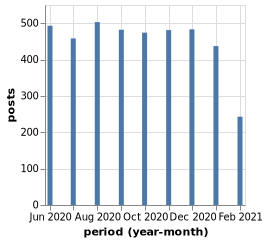

In [7]:
period_posts = combine(
    groupby(transform(posts, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:period]),
    nrow => :num_posts)

period_posts |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"sum(num_posts)", axis={title="posts"}},
)

## Topics

In order to find out whether Instagram's algorithm favored some content over the rest, we divided the posts into topics.

**Topics are defined automatically and change with new data**. We use a latent Dirichlet allocation (LDA) to divide the posts into topics. LDA is a commonly-used algorithm that detects topics in documents based on the distribution of words, and allocates a "topic score" to each, so that a document does not have to be linked to just one topic (e.g. a post showing a face and a cat could be classified as 50% topic "faces" and 50% topic "pets").

We divide all posts into twice 5 topics (the number 5 was chosen arbitrarily), first by caption, then by image labels.

### Caption topics

The words in the topics were organized into eight topics. A label was constructed for each topic by interpreting the top words in each topic. Here are posts that score high on an individual caption topic:

In [8]:
gdf = groupby(stack(posts, names(posts, r"cap_top\d+")), :variable);

Based on these posts, and the top words in `topics_caption.csv` the following interpretion was made. In the figure that show the proportion of the topics over time, we can see that the election topics grows in the lasts months:

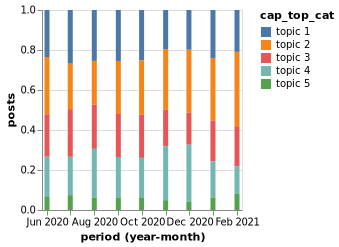

In [9]:
posts.cap_top_cat = recode(string.(posts.cap_top_cat),
    "1" => "topic 1",
    "2" => "topic 2",
    "3" => "topic 3",
    "4" => "topic 4",
    "5" => "topic 5"
);

period_caption = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :cap_top_cat]),
    nrow => :count)

period_caption |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"cap_top_cat:n"})

### Image topics
Images were analyzed with the Google Vision API, and the resulting image tags were organized into eight topics. The post the highest score per topic are listed below:

In [10]:
gdf = groupby(stack(posts, names(posts, r"im_top\d+")), :variable);


Based on these posts, and the top labels in `topics_image.csv` the following interpretation of the image topics was made.

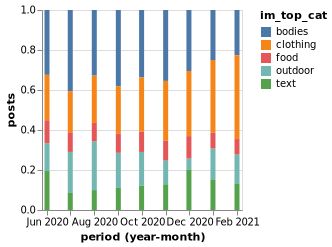

In [11]:
posts.im_top_cat = recode(string.(posts.im_top_cat), 
    "1" => "bodies",
    "2" => "outdoor",
    "3" => "text",
    "4" => "food",
    "5" => "clothing"
);

period_image = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :im_top_cat]),
    nrow => :count)

period_image |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"im_top_cat:n"})

## Donations

Next we load the donations, and display the number of donations over time.

In [12]:
donations = CSV.File("../data/donations.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

donations.post_DOW = categorical(map(Dates.dayname, donations.post_created), levels=Dates.dayname.(1:7));
donations.post_HOD = categorical(map(x -> Dates.value(Dates.Hour(x)), donations.post_created));
donations.post_age = (donations.donation_created - donations.post_created) / convert(Dates.Millisecond, Dates.Hour(1));

donations.likes_cat = cut(donations.likes_count, [0, 5, 10, 100, 1000], extend=true);
donations.comments_cat = cut(donations.comments_count, 5);
donations.post_age_cat = cut(donations.post_age, [1, 3, 24], extend=true);

@show(nrow(donations))

nrow(donations) = 15065


15065

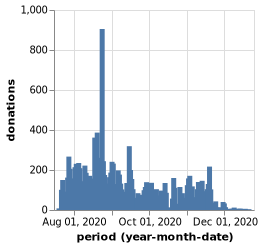

In [13]:
period_donations = combine(
    groupby(transform(donations, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), :period),
    nrow => :num_donations)

period_donations |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonthdate"}, 
    y={"sum(num_donations)", axis={title="donations"}},
)

In [14]:
df = innerjoin(select(donations, Not(:post_created)), posts, on=:post_id);

## RQ1: What posts are overrepresented in the encounters?

To answer this question, we need to describe what posts are overrepresented in general. This might be due to popularity of the post, or due to biases in Instagram’s recommendations. We are interested in topics, derived from words in the caption and from Google Vision API labels for the post’s images.

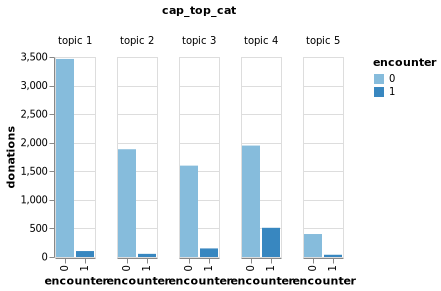

In [15]:
combine(groupby(df, [:cap_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "cap_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = "donations"
)

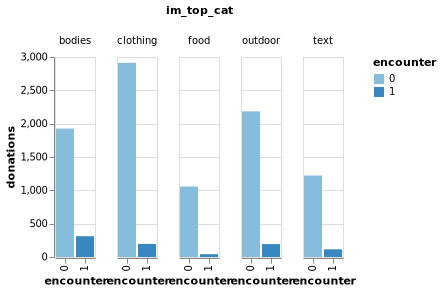

In [16]:
combine(groupby(df, [:im_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "im_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = :donations
)

In [17]:
combine(groupby(df, [:im_top_cat, :encounter]), nrow => :donations)

,im_top_cat,encounter,donations
,String,Int64,Int64
1,clothing,0,2913
2,outdoor,0,2185
3,text,0,1222
4,food,0,1057
5,food,1,42
6,text,1,115
7,clothing,1,196
8,outdoor,1,194
9,bodies,1,312


## RQ2: What posts are overrepresented given their popularity? 
Since overrepresentation is likely to driven by popularity, we analyse what types of posts are overrepresented if we **correct for effects of post popularity**. Remaining variations in post popularity can indicate biases in Instagram’s recommendations. The biases might be limited to the population of donors.

In [18]:
baseline_formula = @formula(encounter ~ 1 
    + log1p(post_age) + log1p(likes_count) + log1p(comments_count) + log1p(follows)
    + post_age_cat + likes_cat + comments_cat
    + post_DOW + post_HOD
    );
baseline_model = glm(baseline_formula, df, Binomial(), LogitLink());
df.pred_popularity = predict(baseline_model, df);

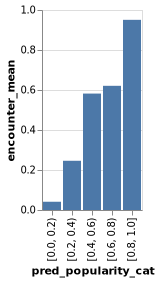

In [19]:
df.pred_popularity_cat = cut(df.pred_popularity, 0:.2:1, extend=true);
combine(groupby(df, :pred_popularity_cat), :encounter=>mean) |> 
    @vlplot(:bar, x="pred_popularity_cat:o", y=:encounter_mean)

This figure shows the encounter frequency is well predicted with the logisitic regression model for popularity. Thus, a large part of the observed encounters can be explained by the presence of competing posts (i.e. time of day or day of week effects), and by the popularity of a post in relation to it's age (through post age, likes and comments). We use this model as a popularity factor, to analyse how much properties of the post content *additionally* changes the probability of encountering a post.

In [29]:
odds(p) = p / (1-p);
logit(p) = log(odds(p));

f2 = @formula(
    encounter ~ 1
        + logit(pred_popularity) # Here we re-use the prediction from the popularity model.
        + (im_top2 + im_top3 + im_top4 + im_top5)
        + (cap_top2 + cap_top3 + cap_top4 + cap_top5)
        + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical
    );

m2 = glm(f2, df, Binomial(), LogitLink());
df.prediction_RQ2 = predict(m2, df);

Now we can compare the predictions of the baseline popularity model, and the model that uses topic information in addition to the popularity factors. Differences between the predictions are due to topics. If a topic results in a increased chance of an encouter, we call this a positive bias. To compute the bias, we convert the predictions of both models to log-odds using the logit transform, and compute the difference.

In [30]:
df.bias = logit.(df.prediction_RQ2) - logit.(df.pred_popularity);

Now we can analyze the bias per caption topic.

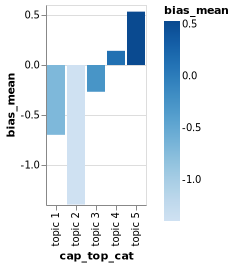

In [31]:
combine(groupby(df, :cap_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="cap_top_cat:o", y=:bias_mean, color=:bias_mean)

Images with the topics `bodies`, and `outdoor` are more likely to reach the donor's feed, while `clothing` and images of `food` are less likely to reach the donor's feed.

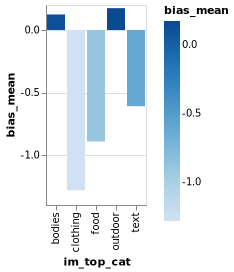

In [37]:
combine(groupby(df, :im_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="im_top_cat:o", y=:bias_mean, color=:bias_mean)

 Note that this bias might not generalize to other posters, and might not generalize to other users than the donors that participated in this experiment.

## RQ3: Is the overrepresentation the same in all subgroups? 

Do the results hold robustly in sub groups? If so, they are more likely to generalize to a wider population. Here we split the data in months, and analyze if the bias is indeed higher for encountered posts than non-encountered posts in each month.

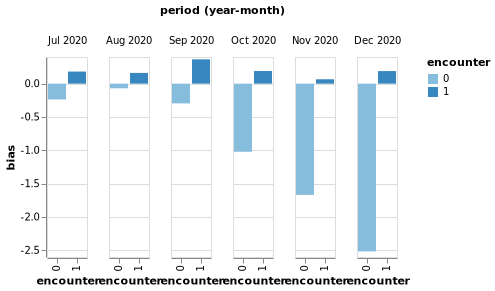

In [33]:
period_bias = combine(
    groupby(transform(df, :post_created => ByRow(t -> floor(t, Dates.Month)) => :period), [:period, :encounter]),
    :bias => mean)

period_bias |> @vlplot(:bar, 
    column={"period:o", timeUnit="yearmonth"}, 
    x = "encounter:o",
    y = {"bias_mean", axis={title="bias"}},
    color = "encounter:o",
)

Within each month, a lower bias is observed for non-encounters than encounters. Thus the bias is robust over different months. Note though that the bias varies strongly from month to month. Since the bias is a function of caption and image topics, this suggests that the *content* has changed from month to month.

# Appendix

#### Image topic 1

![](topic1.jpg)

#### Image topic 2

![](topic2.jpg)

#### Image topic 3

![](topic3.jpg)

#### Image topic 4

![](topic4.jpg)

#### Image topic 5

![](topic5.jpg)

In [25]:
baseline_model

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(log1p(post_age)) + :(log1p(likes_count)) + :(log1p(comments_count)) + :(log1p(follows)) + post_age_cat + likes_cat + comments_cat + post_DOW + post_HOD

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error       z  Pr(>|z|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                           0.0168452  324.744        0.00    1.0000  -636.47      636.504
log1p(post_age)                      -0.826284     0.111979    -7.38    <1e-12    -1.04576    -0.606809
log1p(likes_count)                    0.425347     0.0651977    6.52    <1e-10     0.297

In [34]:
m2

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(logit(pred_popularity)) + im_top2 + im_top3 + im_top4 + im_top5 + cap_top2 + cap_top3 + cap_top4 + cap_top5 + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                       Coef.   Std. Error      z  Pr(>|z|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                     -0.65652        0.230316   -2.85    0.0044    -1.10793     -0.205109
logit(pred_popularity)           0.929612       0.0324547  28.64    <1e-99     0.866001     0.993222
im_top2